# Neural Network-based Models

Importing relevant packages and libraries.

In [57]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from typing import List
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dropout, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence 
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from keras.wrappers.scikit_learn import KerasClassifier  
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from keras.losses import MeanAbsoluteError
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import load_model
import pickle
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import confusion_matrix

### 1. Downloading Data

In [58]:
df_train = pd.read_csv("ATML2023_reviews_train.csv")

Taking a look at the first two rows of the training data set.

In [59]:
df_train.head(2)

,Id,product_id,reviewer_id,rating,review_body,review_title,language,product_category
0,0,pid_7930618,comment_user_0166666,5,Nice addition to my new kurig. Has kept coffee...,Keeps coffee hot for a long time,en,kitchen
1,1,pid_7750075,comment_user_0337482,2,The finger hole is small. Not suitable for a l...,Not adjustable,en,office_product


In [60]:
df_test = pd.read_csv("ATML2023_reviews_test.csv")


In [61]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (164000, 8)
Test: (41000, 7)


There are a total of 164000 rows and 8 columns in the train set . There are a total of 41000 rows and 7 columns (excluding the response) in the test set.

### 2. Data-Preprocessing

The `'review_title'` and `'review_body'` are combined together. The model performs better when the two columns are combined.

In [62]:
df_train['review_body'] = df_train['review_title'] + ' ' + df_train['review_body']

In [63]:
df_test['review_body'] = df_test['review_title'] + ' ' + df_test['review_body']

NA's and duplicates are dropped and the index is reset in the train set. 

In [64]:
df_train = df_train.dropna().drop_duplicates().reset_index(drop=True)


Upper-cased words are lowered in both data sets.

In [65]:
df_train['review_body'] = df_train['review_body'].apply(lambda x: x.lower())


In [66]:
df_test['review_body'] = df_test['review_body'].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [67]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (163975, 8)
Test: (41000, 7)


The resulting shapes are 163975 rows and 8 columns in the train set and a total of 41000 rows and 7 columns (excluding the response) in the test set. 

### 3. Getting text data

Rearranging the data for training.

In [68]:
text_data = df_train[['review_body', 'rating']]

In [69]:
text_data_test=df_test['review_body'] 

### 4. Splitting the Data

The training data set is split into test and training sets, to be able to evaluate the model. Here, we use test size = $20\%$ which results in the same size as in test dataset

In [70]:
# Split the data into train and test sets
X_train,X_test,Y_train, Y_test = train_test_split(text_data['review_body'], text_data['rating'],test_size=0.2, random_state=977,shuffle=True)

# Print the shapes of the train and test sets
print("Train X set shape:", X_train.shape)
print("Test X set shape:", X_test.shape)
print("Train Y set shape:", Y_train.shape)
print("Test Y set shape:", Y_test.shape)

Train X set shape: (131180,)
Test X set shape: (32795,)
Train Y set shape: (131180,)
Test Y set shape: (32795,)


The 'X_train' and 'X_test' data sets are converted to numpy.

In [71]:
X_train = X_train.to_numpy()

In [72]:
text_data_test=text_data_test.to_numpy()

In [73]:
X_test = X_test.to_numpy()

Both responses ('Y_train' and 'Y_test') are converted to integers.

In [74]:
Y_train= (np.array([int(label) for label in Y_train])).astype(int)
Y_train

array([4, 2, 1, ..., 1, 1, 4])

In [75]:
Y_test= (np.array([int(label) for label in Y_test])).astype(int)
Y_test

array([1, 3, 2, ..., 1, 2, 5])

### 4. Model Fitting Preparation

Defining the vocabulary size and the number of words in a sequence.

In [76]:
max_vocab = 1000

`TextVectorization` is a preprocessing technique used to convert text data into numerical representations that can be used as input to machine learning models. Here, the `TextVectorization` layer is used from keras. The maximum number of tokens is defined as above. All words are lower-cased again and punctuation is stripped. The output of this layer is an integer. The layer is used to transform the 'X_train' data set.
By specifying `"max_vocab"` and enabling the preprocessing step of lowering and stripping punctuation, `TextVectorization` ensures that the vocabulary is limited to a certain size (1000 words) and the text data is preprocessed consistently before tokenization. These settings help in controlling the dimensionality of the vectorized representation and can improve the efficiency and effectiveness of subsequent machine learning models trained on the vectorized data.


In [77]:
vectorize_layer = layers.TextVectorization(max_tokens=max_vocab, standardize='lower_and_strip_punctuation',
                                           output_mode='int', output_sequence_length=None)
vectorize_layer.adapt(X_train)

Further parameters are defined to be used in the neural network-based models. The `EarlyStopping` callback is useful for preventing overfitting and saving computational resources by stopping training when the model's performance on the validation set starts to deteriorate. Here, we allow the model to stop if the validation loss does not improve within those 10 epochs, training will be stopped and the model will be returned with the weights that performed the best on the validation set.

In [78]:
patience = 10  # Number of epochs with no improvement after which training will be stopped
monitor = 'val_loss'  # Metric to monitor for early stopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

### 5. MLP Model

Multilayer Perceptrons (MLP) are a type of neural network commonly used for classification. They consist of simple input layers, hidden abstraction layers and output layers. MLP are considered a baseline neural network model and are easy to implement <a href="#ref">(Brownlee 2022)</a>.

Advantage and disagvantages of MLP model in sequential learning:

Advantages:
- Simple and easy to implement.
- Effective for solving simple classification 
- Efficient training and prediction for small to medium-sized datasets.

Disadvantages:
- Limited ability to capture sequential or temporal dependencies in data.
- Cannot handle variable-length input sequences.
- Prone to overfitting when dealing with high-dimensional data.


### 5a. MLP Model + Hyperparameter Tuning

A sequential model is created as a function. The vectorization layer, defined above, is used as the inital layer. This is followed by an embedding layer, which outputs a vector with length 150, the initializer is defined as 'uniform'. Next, the data is passed through a `GlobalAveragePooling` layer. Then through a Dense, Dropout, Dense and final 'softmax' classification layer. 

A GridSearchCV is perform to tune the number of dense layers, the units of the dense layers and the dropout rate. Kfold is defined as 3.

In [47]:
# # Define the function to create the model
# def MLP(num_layers=1, units=64, dropout_rate=0.1):
#     model = Sequential([
#         vectorize_layer,
#         Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=150, embeddings_initializer='uniform'),
#         GlobalAveragePooling1D()
#     ])
#     for _ in range(num_layers):
#         model.add(Dense(units=units, activation='relu'))
#         model.add(Dropout(rate=dropout_rate))
#     model.add(Dense(units=6, activation='softmax'))
#     model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
#     return model

# # Create KerasClassifier for grid search
# modelMLP = KerasClassifier(build_fn=MLP)

# # Set parameters for grid search
# param_grid = {
#     'num_layers': [1,2, 3],  # Number of dense layers
#     'units': [32,64,128],  # Number of units in dense layers
#     'dropout_rate': [0.1, 0.2], # Dropout rate for dense layers
    
# }
# # Set parameters for cross-validation
# cv = KFold(n_splits=3,random_state=977, shuffle=True).split(X_train,Y_train)
# # Create grid search object
# grid_search = GridSearchCV(estimator=modelMLP, param_grid=param_grid, scoring='accuracy', cv=cv, verbose=0)

# # Fit the grid search to the data
# grid_search.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=128, epochs=150,callbacks=[early_stopping],verbose=0)

# # Extract best parameters and accuracy
# best_params = grid_search.best_params_
# best_accuracy = grid_search.best_score_
# print("Best Parameters for MLP: ", best_params)
# print("Best Accuracy for MLP: ", best_accuracy)


1367/1367 [==============================] - 4s 3ms/step
Best Parameters for MLP:  {'dropout_rate': 0.1, 'num_layers': 3, 'units': 128}
Best Accuracy for MLP:  0.5523555262610061


The best parameters result to be a dropout rate of 0.1, 3 dense layers and dense layer units of 128.

### 5b. MLP

The best parameters from the previous step are implemented in the final model. The model is run for 150 epochs.

In [55]:
MLP_model = Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=150,
                     embeddings_initializer='uniform'),
    layers.GlobalAveragePooling1D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
   
    layers.Dense(6, activation='softmax')
], name="MLP_model")

MLP_model.compile(optimizer=optimizers.Adam(),
                  #loss= tf.losses.Huber(),
                  #metrics=['mae'])
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])
epochs = 150
history_MLP = MLP_model.fit(X_train, Y_train, validation_data=(X_test,Y_test),
                            batch_size=128, epochs=epochs,callbacks=[early_stopping],verbose=0)




In [58]:
# Save the entire model as TensorFlow format
MLP_model.save('MLP_model_tunning', save_format='tf')

INFO:tensorflow:Assets written to: MLP_model_tunning\assets


INFO:tensorflow:Assets written to: MLP_model_tunning\assets


In [20]:
MLP_model_tunning = load_model('MLP_model_tunning')


In [21]:
# _,accuracy = MLP_model_tunning.evaluate(X_test, Y_test)


1025/1025 [==============================] - 3s 2ms/step - loss: 0.9637 - accuracy: 0.5880


The final test accuracy is 0.5880. 

### 4. RNN

The next model considered is a Recurrent Neural Network. These are commonly used in NLP, however, they are difficult to train and implement. RNNs form the basis for more complex models, such as LSTMs, which is why they are implemented next. RNN model cycles through its layers, so each layer will depend on its own earlier input and output values <a href="#ref">(Jurasky et al)</a>.

Advantages and disadvantages of RNN:

Advantages:
- Can handle sequential and temporal data with variable-length input sequences.
- Captures dependencies and context information through recurrent connections.
- Effective in tasks such as language modeling, speech recognition, and time series forecasting.

Disadvantages:
- Gradient vanishing and exploding problems, which affect the learning of long-term dependencies.
- Sequential nature limits parallelization during training.
- Difficulty in capturing very long-term dependencies.


Defining model parameters which will be used in the model.

In [79]:
rnn_units = 128
dropout_rate = 0.1
embedding_dim = 150
num_epochs = 100
num_classes = 6
batch_size = 128
num_rnn_layers = 3

The RNN is implemented as a sequential model consisting of the vectorization layer (defined above), an embedding layer, three SimpleRNN layers, a Dropout and a Dense layer with 'soft-max' optimization. Details are provided below.

In [31]:
# Create RNN model
modelRNN = Sequential([
    vectorize_layer,
    # Add vectorize_layer here if it's a part of the model architecture
    Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim, embeddings_initializer='uniform', mask_zero=True),
    # Add 1st layer
    SimpleRNN(units=rnn_units, activation='relu', return_sequences=True),  # RNN layer with 150 hidden units

    # Add additional RNN layers
    *[SimpleRNN(units=rnn_units, activation='relu', return_sequences=True) for _ in range(num_rnn_layers-2)],
    Dropout(rate=dropout_rate),

    # Add last RNN layer
    SimpleRNN(units=rnn_units, activation='relu', return_sequences=False),  # RNN layer with 150 hidden units, no need to return sequences for the final layer
    Dropout(rate=dropout_rate),  # Dropout layer with 0.1 dropout rate

    Dense(units=num_classes, activation='softmax')  # Dense layer with Softmax activation for predicting 5 classes
])

# Compile the model
modelRNN.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

The model is trained and evaluated on the test sets.

In [ ]:
# Train the model
history = modelRNN.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=(X_test, Y_test),verbose=0)

# Extract accuracy on train set
train_accuracy = history.history['accuracy']

In [32]:
modelRNN.load_weights("RNN_model1_tunning")


In [33]:
#_, accuracyRNN = modelRNN.evaluate(X_test, Y_test)


1025/1025 [==============================] - 39s 37ms/step - loss: 0.9629 - accuracy: 0.5805


This model provides an accuracy of 0.5805, slightly worse than the MLP model. RNN models do not perform very well on large data sets because of the problem of vanishing gradients. This might explain its poor result in comparison to the MLP <a href="#ref">(Jurasky et al)</a>.

### 4. LSTM

Long Short-Term Memory (LSTM) models, are extentions to simple RNN models. This is a more complex model designed to maintain relevant context over time, and thus avoiding the problem of vanishing gradients. The LSTM removes contextual information no longer needed and keeps information which might be needed for future decision-making. This is acheived by including a context layer to the model architecture, in addition to the recurrent neural network layers and through the use of 'gates' which control the flow of information into and out of each unit. All of the 'gates' consist of a feedforward layer, followed by a sigmoid activation function. Values corresponding to 1 from the sigmoid function are kept, and those corresponding to 0 are removed <a href="#ref">(Jurasky et al)</a>.


Advantages:
- Overcomes the gradient vanishing and exploding problems of traditional RNNs.
- Captures long-term dependencies in sequential data.
- Handles variable-length input sequences.
- Effective in tasks requiring modeling of long-term dependencies, such as language translation and sentiment analysis.

Disadvantages:
- More complex architecture compared to traditional RNNs.
- Requires more computational resources and training time.
- May overfit on small datasets if not properly regularized.
- Performance is highly depends on hyper parameters.


The LSTM model is defined as a sequential model with the vectorization layer (defined above), an embedding, LSTM, Dense and 'soft-max' layers. Please see details below.

In [35]:
LSTM_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.LSTM(128),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
], name="LSTM_model")

The model is then compiled.

In [36]:
LSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

It is programmed to train for 100 epochs, however, an early stopping mechanism is defined as well.

In [72]:
# history_lstm = LSTM_model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
#                                batch_size=128, epochs=num_epochs, callbacks=[early_stopping])



Epoch 1/100
1025/1025 [==============================] - 1074s 1s/step - loss: 1.2817 - accuracy: 0.4269 - val_loss: 1.0471 - val_accuracy: 0.5519
Epoch 2/100
1025/1025 [==============================] - 981s 957ms/step - loss: 1.0196 - accuracy: 0.5631 - val_loss: 0.9991 - val_accuracy: 0.5730
Epoch 3/100
1025/1025 [==============================] - 980s 957ms/step - loss: 0.9912 - accuracy: 0.5769 - val_loss: 1.0022 - val_accuracy: 0.5705
Epoch 4/100
1025/1025 [==============================] - 916s 893ms/step - loss: 0.9766 - accuracy: 0.5813 - val_loss: 0.9766 - val_accuracy: 0.5832
Epoch 5/100
1025/1025 [==============================] - 918s 896ms/step - loss: 0.9642 - accuracy: 0.5859 - val_loss: 0.9669 - val_accuracy: 0.5832
Epoch 6/100
1025/1025 [==============================] - 944s 921ms/step - loss: 0.9540 - accuracy: 0.5880 - val_loss: 0.9634 - val_accuracy: 0.5853
Epoch 7/100
1025/1025 [==============================] - 923s 901ms/step - loss: 0.9452 - accuracy: 0.5896 -

The model ran for 37 epochs, at which point its accuracy no longer improved (which is why it stopped).

In [37]:
LSTM_model.load_weights("./Modelfit/LSTM")


In [38]:
_,accuracyLSTM= LSTM_model.evaluate(X_test,Y_test)

1025/1025 [==============================] - 47s 45ms/step - loss: 0.9200 - accuracy: 0.6027


The test accuracy on the LSTM is better than that from the previous models (0.6027). This result is expected, since there is a more complex model architecture which avoids the problem of vanishing gradients.

### 5. Bidirectional LSTM

The Bidirectional LSTM (an extention to the normal LSTM model) consists of two LSTM layers; one taking the input in a forward direction and another taking the input in a backwards direction. This model architecture increases the amount of information and 'context' available to the model. It models the sequential dependencies in a text in both directions <a href="#ref">(Medium 2022)</a>.

Advantages:
- Captures dependencies from both past and future contexts.
- Incorporates a wider range of information for prediction.
- Well-suited for tasks that require a comprehensive understanding of the input sequence.

Disadvantages:
- Increased computational complexity due to processing in both directions.
- Requires more memory compared to unidirectional LSTMs.
- May not be necessary for tasks where future context is irrelevant.
This BLSTM model consists of 8 layers. The first is an embedding layer, which is then followed by the 2 bidirectional LSTM layers. Then two sets of Dense and Dropout layers have been added, followed by the final Dense layer with a 'softmax' activation which is responsible for final classification. 

In [52]:
BLSTM_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True), merge_mode='concat'),
    layers.Bidirectional(layers.LSTM(32,  return_sequences=False), merge_mode='concat'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
], name="BLSTM_model")

The defined model is compiled with an Adam optimizer, a relatively slow learning rate, the `SparseCategoricalCrossentropy` loss function, which computes the crossentropy loss between the labels and predictions and is appropriate for models with multiple classes, and 'accuracy' as the metrics. `SparseCategoricalCrossentropy` is also an appropriate loss function when multiple classes are coded as integers, as opposed to one-hot matrix. Relatively slow learning rate is beneficial with complex models, in order to allow the model to gradually converge towards the optimal parameters. It thus allows smoother convergence and better estimates the gradient.

In [53]:
BLSTM_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

Again the model is fit for 100 epochs with early stopping.

In [30]:
# history_BLSTM = BLSTM_model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
#                                batch_size=128, epochs=num_epochs, callbacks=[early_stopping])

Epoch 1/100
1025/1025 [==============================] - 547s 529ms/step - loss: 1.3437 - accuracy: 0.4058 - val_loss: 1.0470 - val_accuracy: 0.5583
Epoch 2/100
1025/1025 [==============================] - 550s 537ms/step - loss: 1.0461 - accuracy: 0.5566 - val_loss: 0.9878 - val_accuracy: 0.5801
Epoch 3/100
1025/1025 [==============================] - 571s 557ms/step - loss: 0.9994 - accuracy: 0.5747 - val_loss: 0.9681 - val_accuracy: 0.5861
Epoch 4/100
1025/1025 [==============================] - 567s 553ms/step - loss: 0.9769 - accuracy: 0.5822 - val_loss: 0.9542 - val_accuracy: 0.5875
Epoch 5/100
1025/1025 [==============================] - 570s 556ms/step - loss: 0.9610 - accuracy: 0.5866 - val_loss: 0.9498 - val_accuracy: 0.5903
Epoch 6/100
1025/1025 [==============================] - 588s 574ms/step - loss: 0.9484 - accuracy: 0.5911 - val_loss: 0.9416 - val_accuracy: 0.5928
Epoch 7/100
1025/1025 [==============================] - 571s 557ms/step - loss: 0.9398 - accuracy: 0.5947

The model stops after 38 epochs, at which point its accuracy is no longer improving.

In [55]:
BLSTM_model.load_weights("./Modelfit/BLSTM")

In [43]:
_,accuracyBLSTM= BLSTM_model.evaluate(X_test,Y_test)

1025/1025 [==============================] - 56s 49ms/step - loss: 0.9058 - accuracy: 0.6048


The accuracy on the test data set of the BLSTM model is slightly better than that of the normal LSTM model, which is again expected sincee the BLSTM model can capture both 'future' and 'past' context, thus allowing for better understanding of the context.

#### Confusion matrix

A confusion matrix is plotted to see how the model performs, overall.

In [26]:

# Get the predicted labels
Y_pred_BLSTM = np.argmax(BLSTM_model.predict(X_train), axis=1)

# Create the confusion matrix
conf_matrix_BLSTM = confusion_matrix(Y_train, Y_pred_BLSTM)

4100/4100 [==============================] - 285s 67ms/step


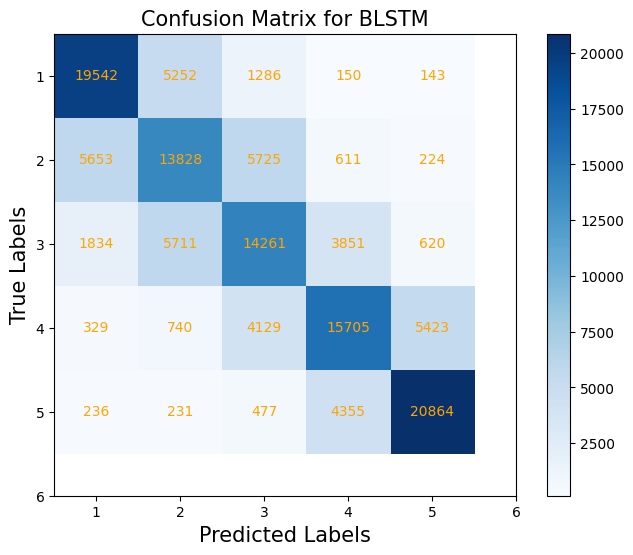

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_BLSTM, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for BLSTM', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
# Replace x-axis and y-axis ticks
ticks = np.arange(0, num_classes)
labels = [str(i) for i in range(1, num_classes+1)]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        try:
            plt.text(j, i, conf_matrix_BLSTM[i, j], ha='center', va='center', color='orange')
        except IndexError:
            pass
plt.show()


It can be seen that the model does realtively well capturing all 5 classes, especially in rating 1 and rating 5. It is also curious to notice the specific pattern of surrrounding classes: the nearby classes, e.g. 1 and 2, are harder to distinguish than the classes further apart, e.g. 1 and 5.

### 6. GRU

The Gated Recurrent Unit (GRU) is another model which tries to solve the vanishing gradient problem of simple RNN models. These models can also be considered an extention to the LSTM model. The GRU uses the 'update gate', 'reset gate' units, which decide the information that is passed to the output. This model can keep information for a long period, without washing it through time <a href="#ref">(Simeon Kostadinov 2017)</a>. 

Advantages:
- Simplified architecture compared to LSTM, leading to faster training and lower memory requirements.
- Effective in capturing short-term dependencies in sequential data.
- Handles variable-length input sequences.

Disadvantages:
- May not perform as well as LSTM in tasks requiring modeling of long-term dependencies.
- Limited capacity to capture complex sequential patterns.
- May still suffer from gradient vanishing and exploding problems.

The GRU is set up as a sequential model, with the vectorization layer defined above. Other layers include an embedding, a GRU, a Dense and a 'softmax' layer. 

In [80]:
GRU_model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=embedding_dim,
                     embeddings_initializer='uniform', mask_zero=True),
    layers.GRU(128),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
], name="GRU_model")


The model is compiled as usual.

In [81]:
GRU_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
#history_gru = GRU_model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                               #batch_size=128, epochs=num_epochs, callbacks=[early_stopping])

In [82]:
GRU_model.load_weights("./GRU")

In [83]:
_,accuracyGRU=GRU_model.evaluate(X_test,Y_test)

1025/1025 [==============================] - 57s 52ms/step - loss: 0.9010 - accuracy: 0.6102


The accuracy of the GRU (0.6102) is better than all previous models. Through an optimised architecture, a GRU model has less vanishing gradients, thus the available information is used more efficiently. Another advantage of this model is the lower risk of overfitting.

### 6.1 Confusion matrix

A confusion matrix will be plotted to analyse the models performance.

In [87]:

# Get the predicted labels
Y_pred_GRU = np.argmax(GRU_model.predict(X_train), axis=1)

# Create the confusion matrix
conf_matrix_GRU = confusion_matrix(Y_train, Y_pred_GRU)

4100/4100 [==============================] - 179s 43ms/step


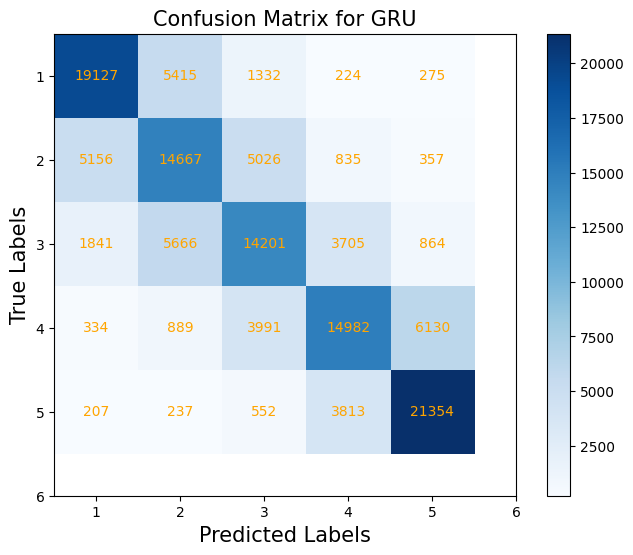

In [88]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_GRU, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for GRU', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
# Replace x-axis and y-axis ticks
ticks = np.arange(0, num_classes)
labels = [str(i) for i in range(1, num_classes+1)]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.colorbar()
for i in range(num_classes):
    for j in range(num_classes):
        try:
            plt.text(j, i, conf_matrix_GRU[i, j], ha='center', va='center', color='orange')
        except IndexError:
            pass
plt.show()


As with the BLSTM, it can be seen that the model does a good job at classifying all 5 classes, especially the first and the last class. Again, the same surrounding pattern (around the main diagonal) is observed here.

### 6.2 Accuracy plot

Training and test accuracy is also plotted to depict the training and test history.

In [91]:
with open('history_gru.pkl', 'rb') as file:
    history_gru_dict = pickle.load(file)

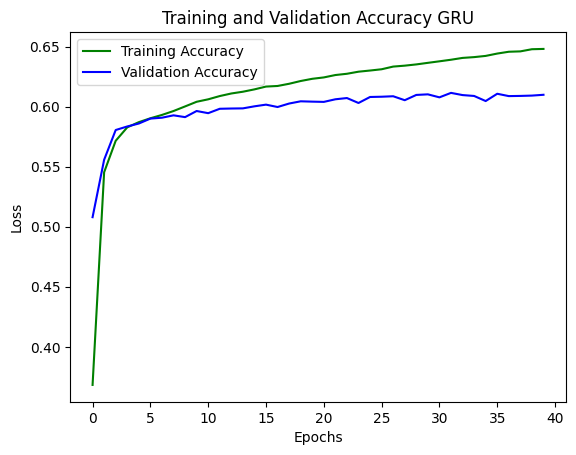

In [100]:
accuracy_train_GRU = history_gru['accuracy']  # ['accuracy', 'loss', 'val_accuracy', 'val_loss']
accuracy_val_GRU = history_gru['val_accuracy']
epochs = range(0,40)
plt.plot(epochs, accuracy_train_GRU, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val_GRU, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It can be seen that the training accuracy increases at a faster rate than validation accuracy. This is what we would expect.

### 6.3 Loss plot

In [ ]:
with open('history_gru.pkl', 'rb') as file:
    history_gru_dict = pickle.load(file)

In [ ]:
history_gru = {}

# Assign the loaded values to the dictionary
history_gru['loss'] = history_gru_dict['loss']
history_gru['accuracy'] = history_gru_dict['accuracy']
history_gru['val_loss'] = history_gru_dict['val_loss']
history_gru['val_accuracy'] = history_gru_dict['val_accuracy']

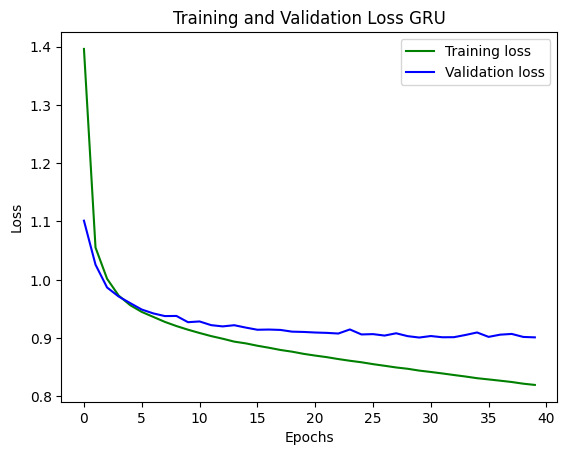

In [101]:
loss_train_GRU = history_gru['loss']  # ['accuracy', 'loss', 'val_accuracy', 'val_loss']
loss_val_GRU = history_gru['val_loss'] 
epochs = range(0,40)
plt.plot(epochs, loss_train_GRU, 'g', label='Training loss')
plt.plot(epochs, loss_val_GRU, 'b', label='Validation loss')
plt.title('Training and Validation Loss GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The loss functions represent the opposite of the accuracy plots. The conclusions are the same.

### 7. Model selection

Test accuracy for all models are presented below. The best models turned out to be the LSTM-related models. 

In [3]:
print("Accuracy of KNN on test set: 0.4683030949839915" )


Accuracy of KNN on test set: 0.4683030949839915


In [44]:

print("Accuracy of Logistic Regression on test set: 0.5755450525994816" )
print("Accuracy of MLP model on test set: ", accuracy)
print("Accuracy of RNN on test set: ", accuracyRNN)
print("Accuracy of LSTM on test set: ", accuracyLSTM)
print("Accuracy of BLSTM on test set: ", accuracyBLSTM)


Accuracy of Logistic Regression on test set: 0.5755450525994816
Accuracy of MLP model on test set:  0.5880164504051208
Accuracy of RNN on test set:  0.5804543495178223
Accuracy of LSTM on test set:  0.6027138233184814
Accuracy of BLSTM on test set:  0.604787290096283


In [102]:
print("Accuracy of GRU on test set: ", accuracyGRU)


Accuracy of GRU on test set:  0.6101844906806946


In [24]:
print("Accuracy of Transformer on test set: 0.4272" )


Accuracy of Transformer on test set: 0.4272


Here, we select the model which yields the best accuracy which is GRU. However, we also ackowledge some limitations: 

- Hyperparameter tuning plays a crucial role in optimizing the performance of machine learning models. However, if hyperparameters are not tuned properly for RNN, LSTM, BiLSTM, and GRU models, it can lead to suboptimal performance. These models have various hyperparameters such as learning rate, number of layers, hidden units, etc., that need to be carefully tuned to achieve the best results. Failing to do so may limit the performance of these models.

- The Transformer architecture has demonstrated excellent performance in various natural language processing tasks, especially for large-scale datasets. In optimal conditions, where hyperparameters are well-tuned and the model is trained on a sufficient amount of data, and with powerful computational machines the Transformer model can outperform traditional recurrent-based models like RNN, LSTM, BiLSTM, and GRU. However, under the limited computational- and time resources, we believe the Transformer did not get the chance to show its full potential.

- Choosing the best model based only on accuracy and confusion matrix: while accuracy and confusion matrix provide valuable insights into model performance, they do not guarantee that the model will generalize well to unseen data. 

For the purpose of this project, we do not aim to achieve the highest accuracy. Instead, our goal is to explore and apply a variety of preprocessing methods, embedding methods, and sequential learning models to gain a better understanding of the content. By doing so, we aim to analyze and compare the performance of these different techniques and their impact on the task at hand.

<h2 id="ref">References</h2>

1. Medium 2014, *Text Messages Classification using LSTM, BiLSTM and GRU*, Towards Data Science, viewed 6 May 2023. https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

2. Jason Brownlee 2022, *When to Use MLP, CNN and RNN Neural Networks*, Machine Learning Mastery, viewed 17 May 2023. https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/

3. Jurafsky, D., James H. M. (2023). Speech and Language Processing (3rd ed. draft), available <a href="https://web.stanford.edu/

4. Simeon Kostadinov (2017). *Understanding GRU Networks*, Towards Data Science, viewed 17 May 2023. https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be